### Check the landmasking in the boundary conditions files

- check surface FW fluxes in weddell sea region
- run with Chris' version and follow up
- look up form drag ice/atmosphere


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean

#### Functions

#### Read files

In [38]:
# running with bdy_ind = -1, for domain of size 453, so should be index 151 I think.
terra = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/'
domain_cfg = xr.open_dataset(f'{terra}bathymetry/domain_cfg-20240123-filledlakes.nc')
mesh_mask  = xr.open_dataset(f'{terra}bathymetry/mesh_mask-20240123-filledlakes.nc').isel(time_counter=0)
bdy_cond     = xr.open_dataset(f'{terra}boundary-conditions/B-SOSE/SOSE-SALT-boundary-conditions-20240125_m01.nc').isel(time_counter=0)
bdy_cond_new = xr.open_dataset(f'{terra}boundary-conditions/B-SOSE/SOSE-SALT-boundary-conditions-20240219_m01.nc').isel(time_counter=0)
bdy_cond_T  = xr.open_dataset(f'{terra}boundary-conditions/B-SOSE/SOSE-THETA-boundary-conditions-20240219_m01.nc').isel(time_counter=0)
bdy_cond_S  = xr.open_dataset(f'{terra}boundary-conditions/B-SOSE/SOSE-SALT-boundary-conditions-20240219_m01.nc').isel(time_counter=0)
bdy_cond_SSH= xr.open_dataset(f'{terra}boundary-conditions/B-SOSE/SOSE-SSH-boundary-conditions-20240219_m01.nc').isel(time_counter=0)
bdy_cond_U  = xr.open_dataset(f'{terra}boundary-conditions/B-SOSE/SOSE-Uvel-boundary-conditions-20240221_m01.nc').isel(time_counter=0)
bdy_cond_V  = xr.open_dataset(f'{terra}boundary-conditions/B-SOSE/SOSE-Vvel-boundary-conditions-20240221_m01.nc').isel(time_counter=0)

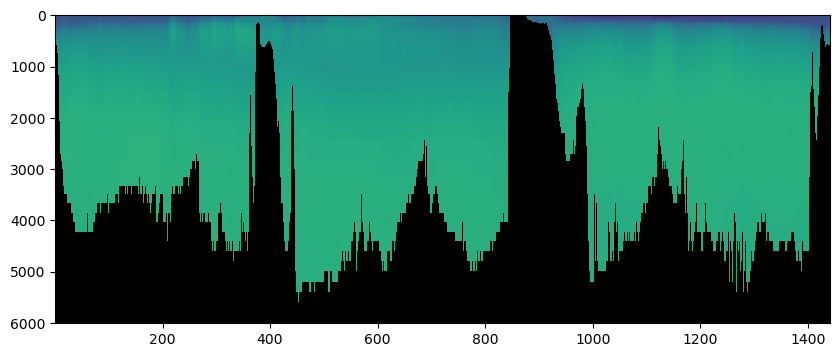

In [155]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.invert_yaxis()
ax.pcolormesh(np.arange(2,1442,1), domain_cfg.nav_lev, bdy_cond_T.SALT.isel(y=0), vmin=33, vmax=36)
plot_land = np.ma.masked_where(mesh_mask.tmask.isel(y=451)==1, mesh_mask.tmask.isel(y=451))
ax.pcolormesh(np.arange(1,1441,1), domain_cfg.nav_lev, plot_land, cmap=cmocean.cm.gray)

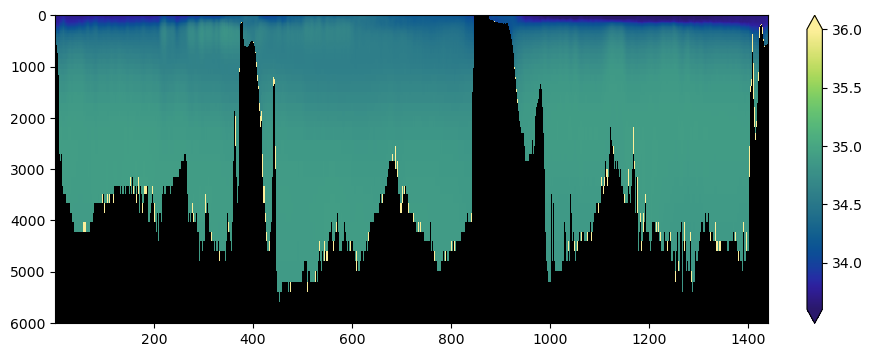

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.invert_yaxis()

cm1 = ax.pcolormesh(np.arange(1,1441,1), domain_cfg.nav_lev, bdy_cond.SALT.isel(y=0), vmin=33.6, vmax=36, cmap=cmocean.cm.haline)
plot_land = np.ma.masked_where(mesh_mask.tmask.isel(y=451)==1, mesh_mask.tmask.isel(y=451))
ax.pcolormesh(np.arange(1,1441,1), domain_cfg.nav_lev, plot_land, cmap=cmocean.cm.gray)
CB1 = fig.colorbar(cm1, ax=ax, fraction=0.03, extend='both')

In [41]:
print(np.argwhere((mesh_mask.tmask.isel(y=452).values==1)*(bdy_cond.SALT.values==9999)))
print(np.argwhere((mesh_mask.tmask.isel(y=451).values==1)*(bdy_cond_new.SALT.values==9999)))

[]
[]


Let's have a look at the output after the first time steps:

In [24]:
ds0  = xr.open_dataset(f'{terra}output/new-setup-testing/BDY_1/test12/eANT025.L121_1m_19790101_19790304_grid_T.nc').isel(time_counter=0)
ds1  = xr.open_dataset(f'{terra}output/new-setup-testing/BDY_1/test12/eANT025.L121_1m_19790101_19790304_grid_T.nc').isel(time_counter=1)
# ds10 = xr.open_dataset(f'{terra}output/new-setup-testing/BDY_1/test12/eANT025.L121_1ts_19790101_19790102_grid_U_19790101000000-19790101072959.nc').isel(time_counter=8)

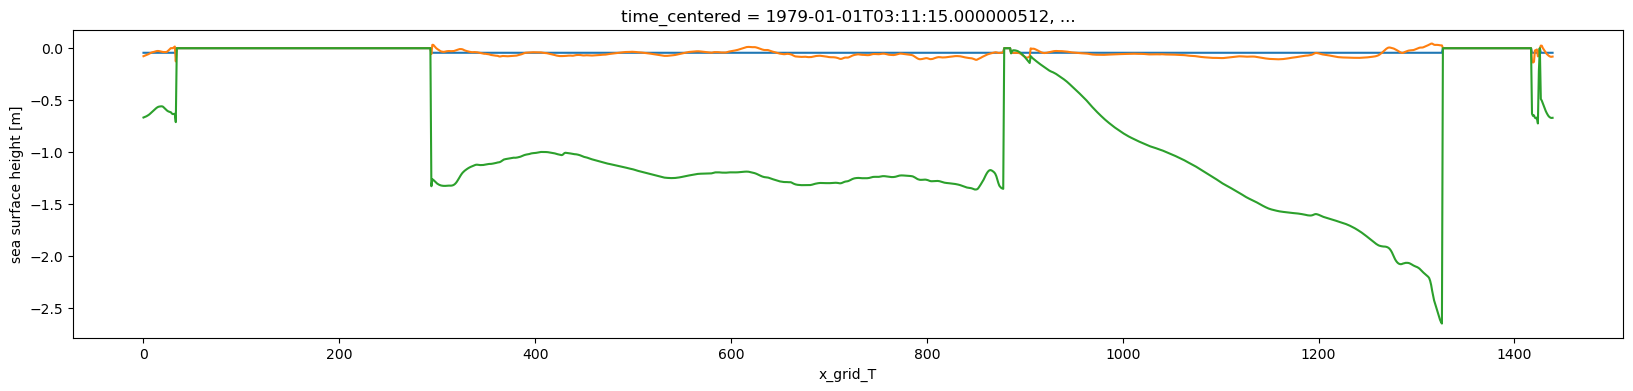

In [7]:
cell = 310

fig, ax = plt.subplots(1,1, figsize=(20,4))
ds0.zos.isel(y_grid_T=cell).plot()
ds1.zos.isel(y_grid_T=cell).plot()
ds10.zos.isel(y_grid_T=cell).plot()

In [19]:
def plot_cross_section(ds, yind=451, ylim=(6000,0), xlim=(0,1440), vlim=(34,35), cmap=cmocean.cm.haline):
    try:
        ds_plot = ds.isel(y_grid_T=yind)
    except:
        ds_plot = ds.isel(y=yind)
    
    fig, ax = plt.subplots(1,1, figsize=(20,4))
    ax.invert_yaxis()
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_xlim(xlim[0], xlim[1])
    cm1 = ax.pcolormesh(np.arange(1,1441,1), domain_cfg.nav_lev, ds_plot, vmin=vlim[0], vmax=vlim[1], cmap=cmap)
    CB1 = fig.colorbar(cm1, ax=ax, fraction=0.03, extend='both')
    return fig, ax

#### U velocity:

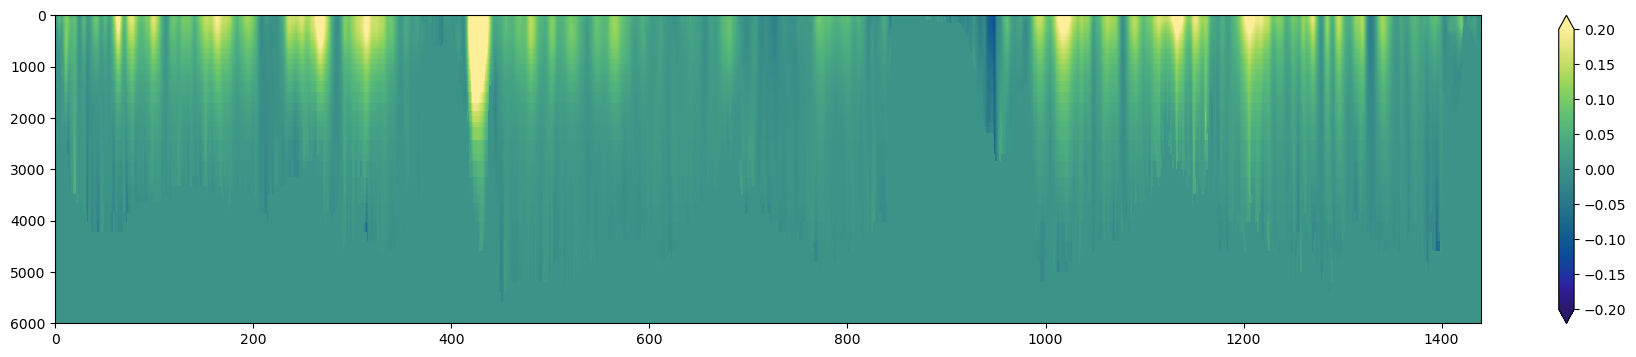

In [17]:
fig, ax = plot_cross_section(bdy_cond_U.UVEL, yind=0, vlim=(-0.2,0.2))

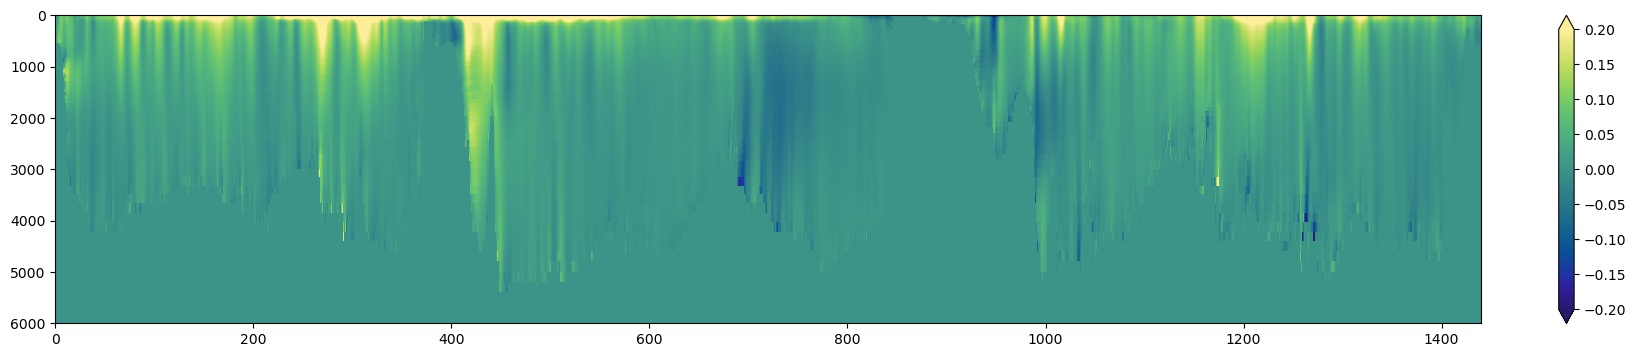

In [11]:
fig, ax = plot_cross_section(ds0.uo, yind=450, vlim=(-0.2,0.2))

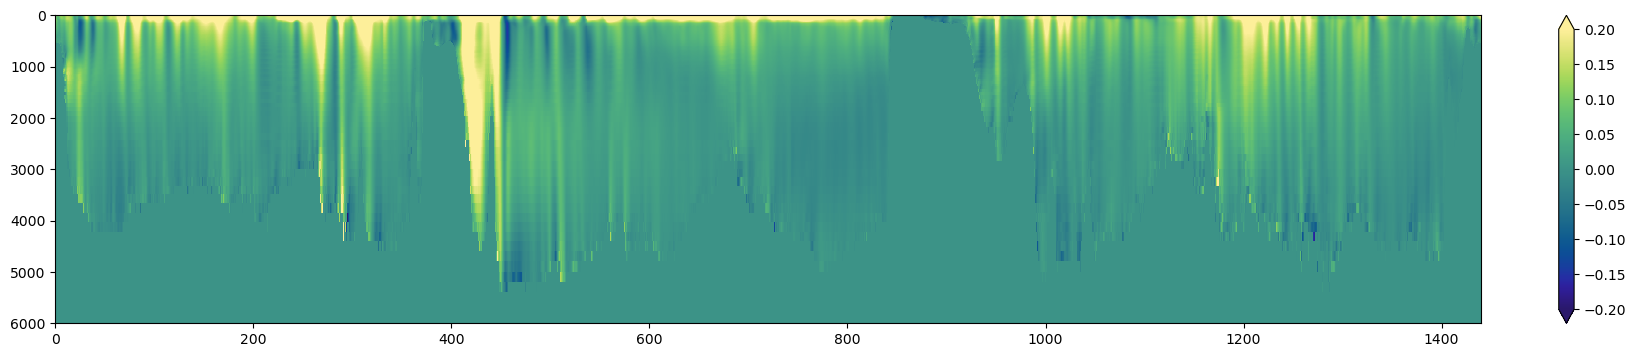

In [12]:
fig, ax = plot_cross_section(ds1.uo, yind=450, vlim=(-0.2,0.2))

#### V velocity

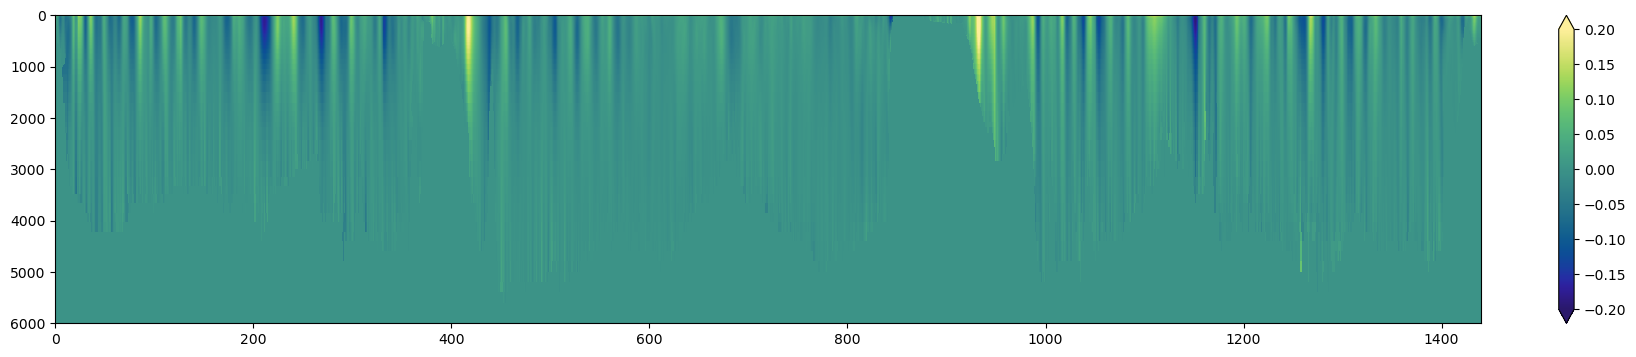

In [20]:
fig, ax = plot_cross_section(bdy_cond_V.VVEL, yind=0, vlim=(-0.2,0.2))

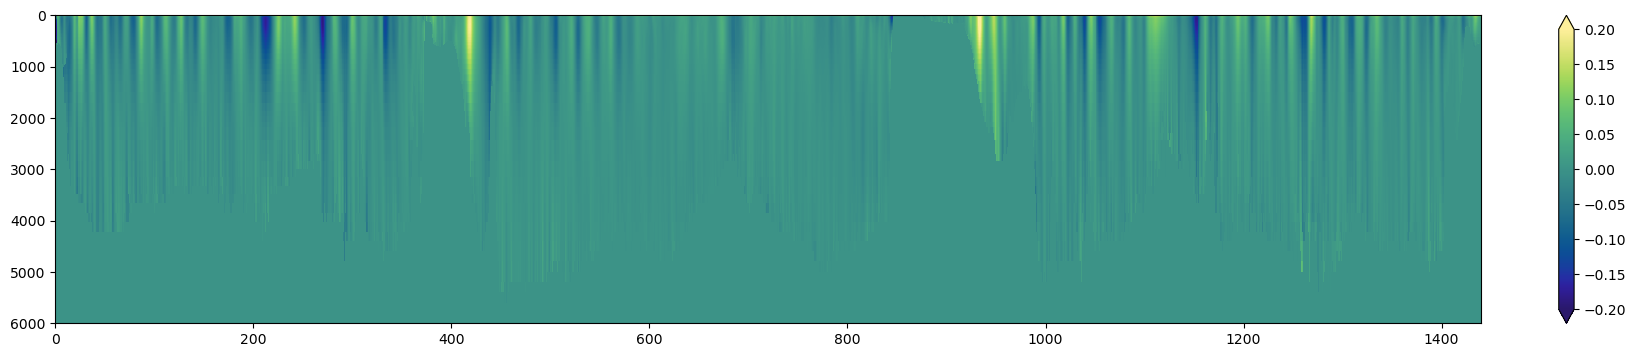

In [22]:
fig, ax = plot_cross_section(ds0.vo, yind=450, vlim=(-0.2,0.2))

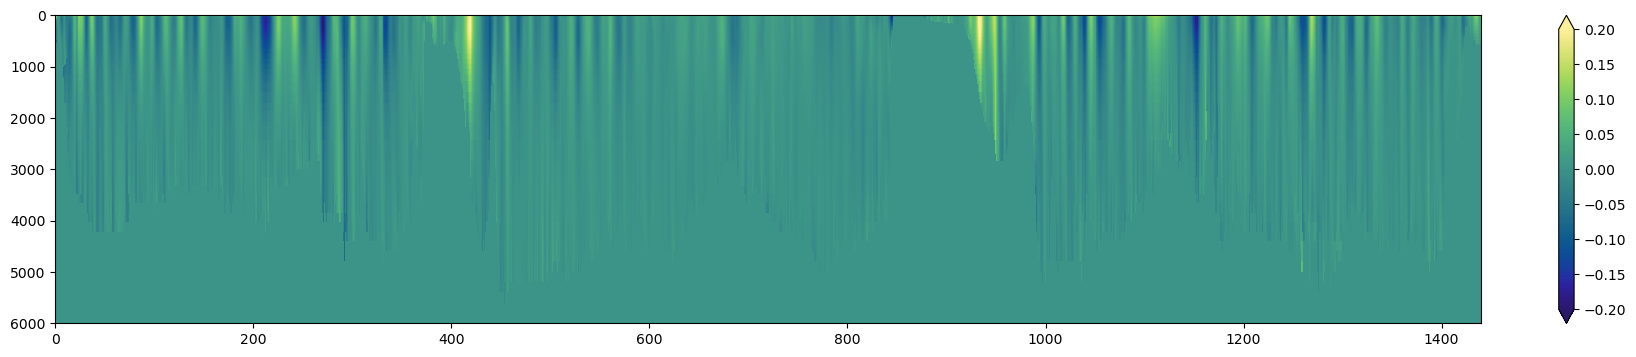

In [23]:
fig, ax = plot_cross_section(ds1.vo, yind=450, vlim=(-0.2,0.2))

#### Temperature

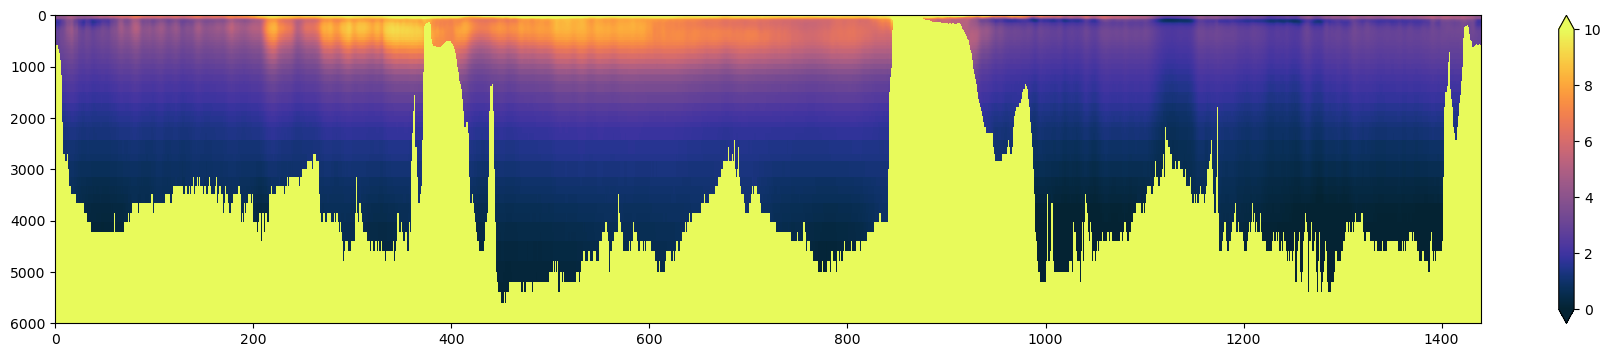

In [32]:
fig, ax = plot_cross_section(bdy_cond_T.THETA, yind=0, vlim=(0,10), cmap=cmocean.cm.thermal)

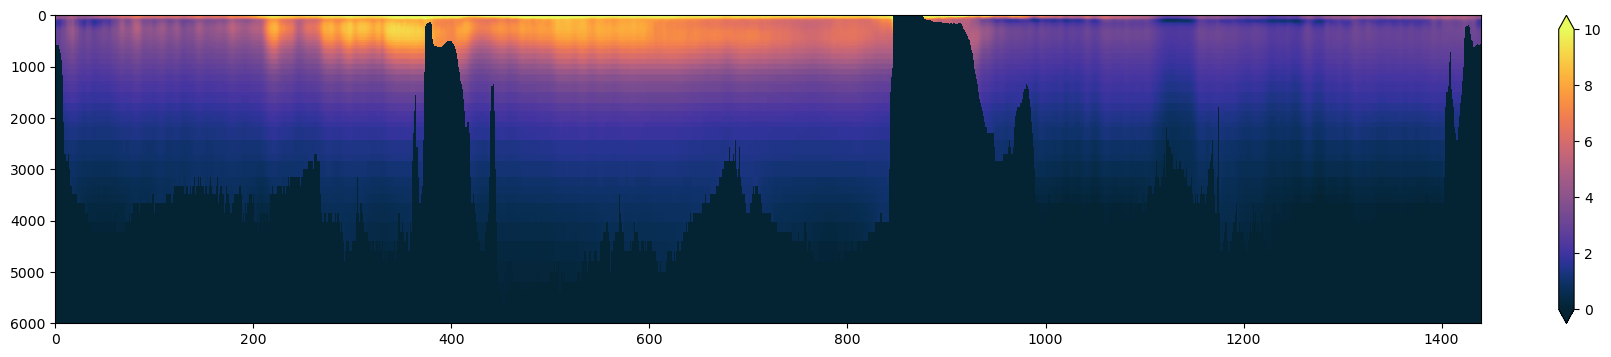

In [28]:
fig, ax = plot_cross_section(ds0.thetao, yind=451, vlim=(0,10), cmap=cmocean.cm.thermal)

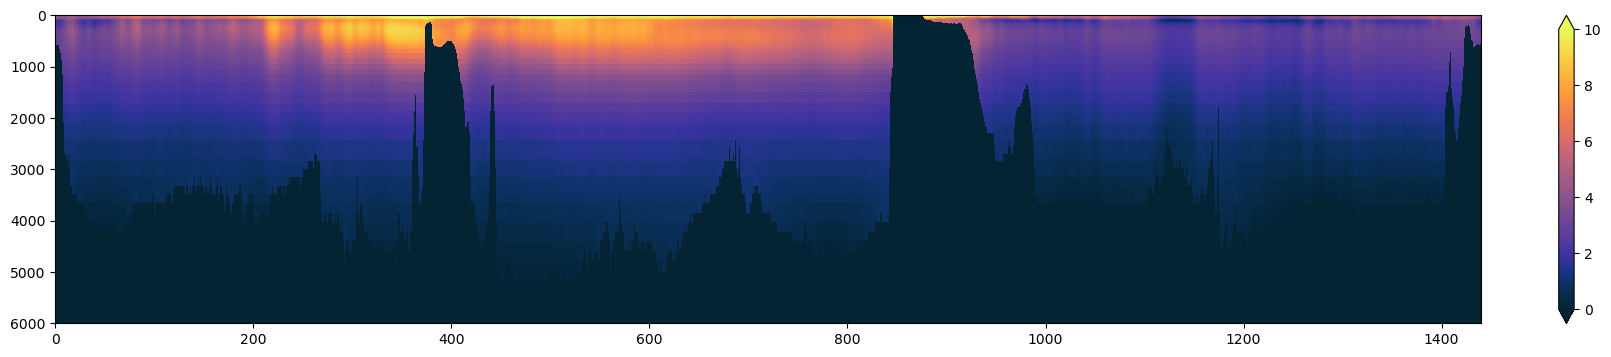

In [26]:
fig, ax = plot_cross_section(ds1.thetao, yind=451, vlim=(0,10), cmap=cmocean.cm.thermal)

#### Salinity

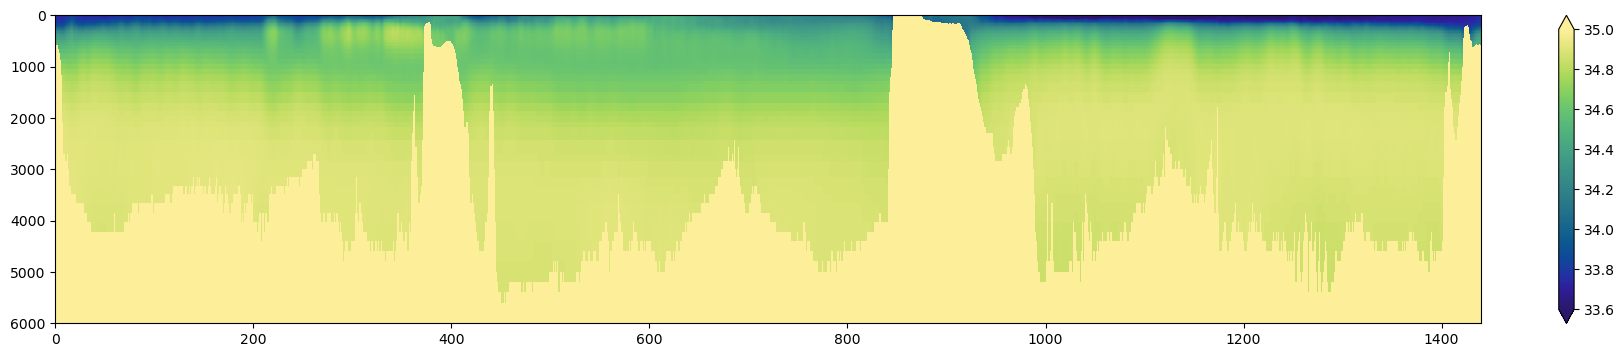

In [33]:
fig, ax = plot_cross_section(bdy_cond_S.SALT, yind=0, vlim=(33.6,35))

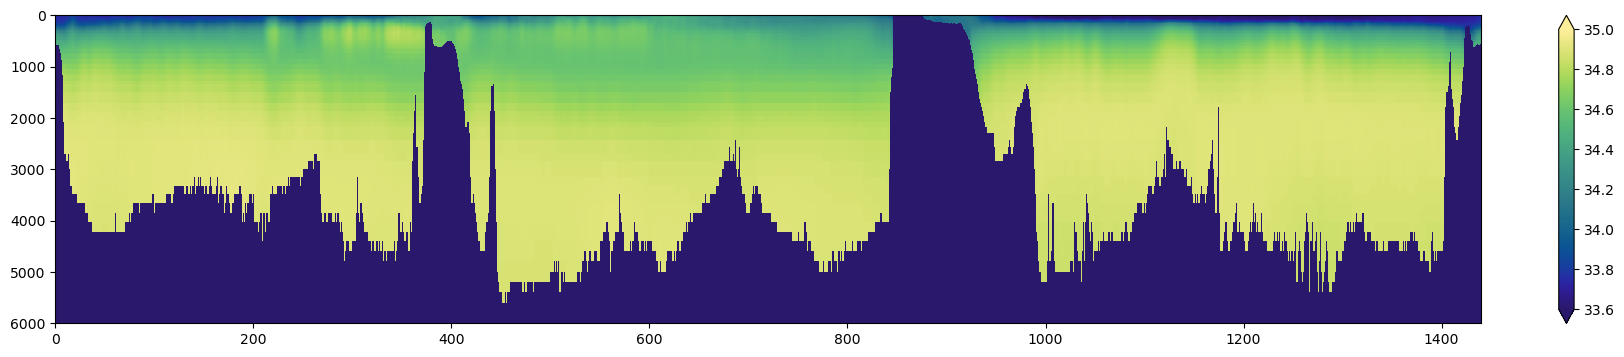

In [34]:
fig, ax = plot_cross_section(ds0.so, yind=451, vlim=(33.6,35))

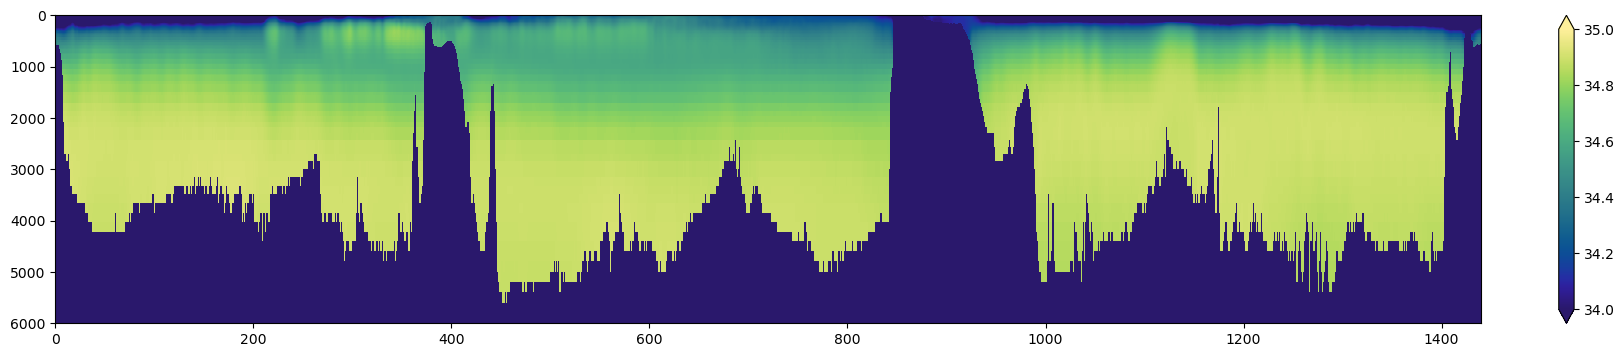

In [35]:
fig, ax = plot_cross_section(ds1.so, yind=451)

#### SSH

(-1.5, 0.5)

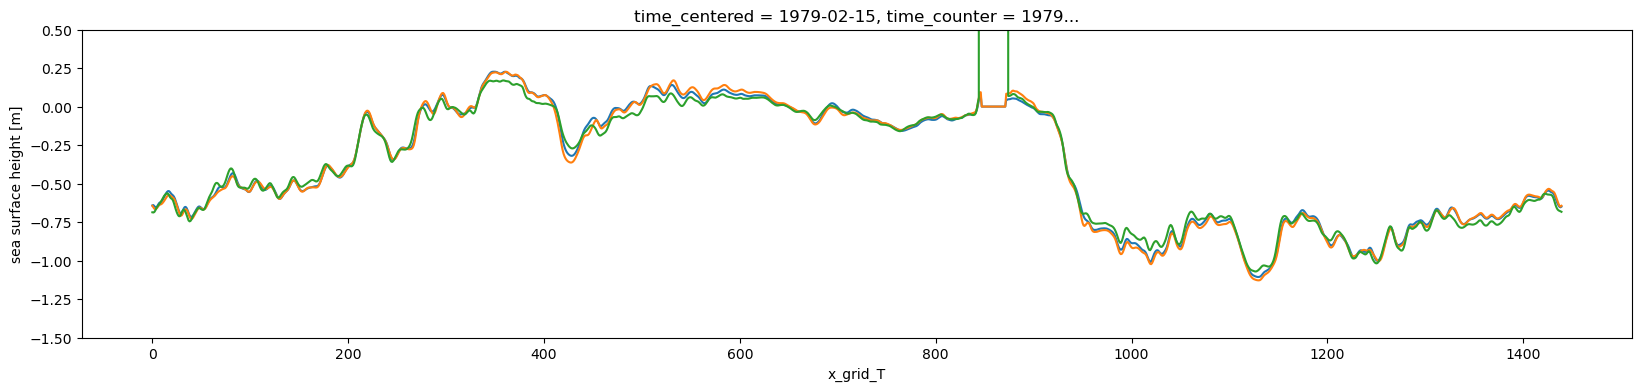

In [50]:
cell = 451
fig, ax = plt.subplots(1,1, figsize=(20,4))
ds0.zos.isel(y_grid_T=cell).plot()
ds1.zos.isel(y_grid_T=cell).plot()
ax.plot(ds0.zos.x_grid_T, bdy_cond_SSH.ETAN.isel(y=0))
ax.set_ylim(-1.5,0.5)

### Check boundary condition files

In [92]:
month=8
bdy_cond_T  = xr.open_dataset(f'{terra}boundary-conditions/B-SOSE/SOSE-THETA-boundary-conditions-20240228_m{month:02}.nc').isel(time_counter=0)
bdy_cond_S  = xr.open_dataset(f'{terra}boundary-conditions/B-SOSE/SOSE-SALT-boundary-conditions-20240228_m{month:02}.nc').isel(time_counter=0)
bdy_cond_SSH= xr.open_dataset(f'{terra}boundary-conditions/B-SOSE/SOSE-SSH-boundary-conditions-20240228_m{month:02}.nc').isel(time_counter=0)
bdy_cond_U  = xr.open_dataset(f'{terra}boundary-conditions/B-SOSE/SOSE-Uvel-boundary-conditions-20240228_m{month:02}.nc').isel(time_counter=0)
bdy_cond_V  = xr.open_dataset(f'{terra}boundary-conditions/B-SOSE/SOSE-Vvel-boundary-conditions-20240228_m{month:02}.nc').isel(time_counter=0)

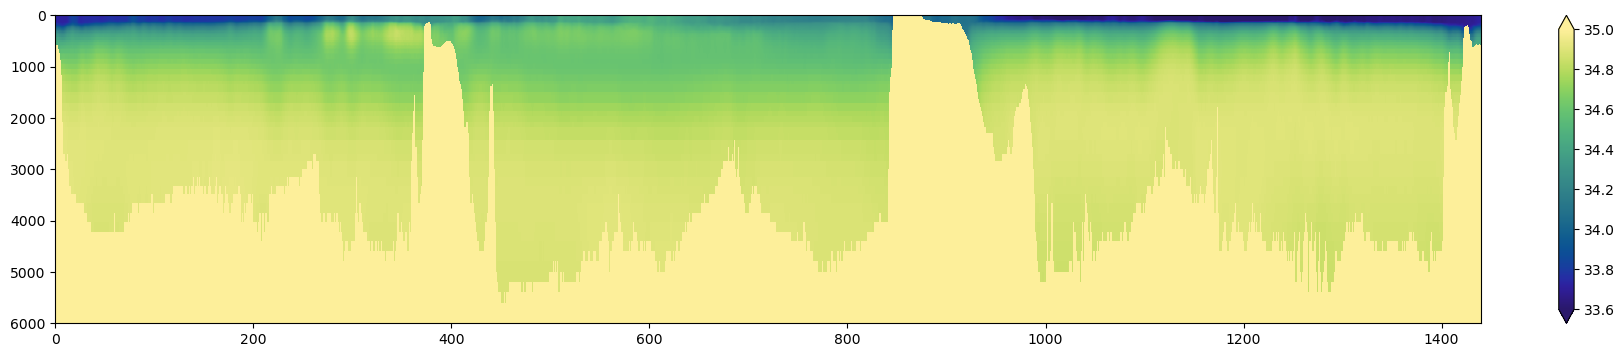

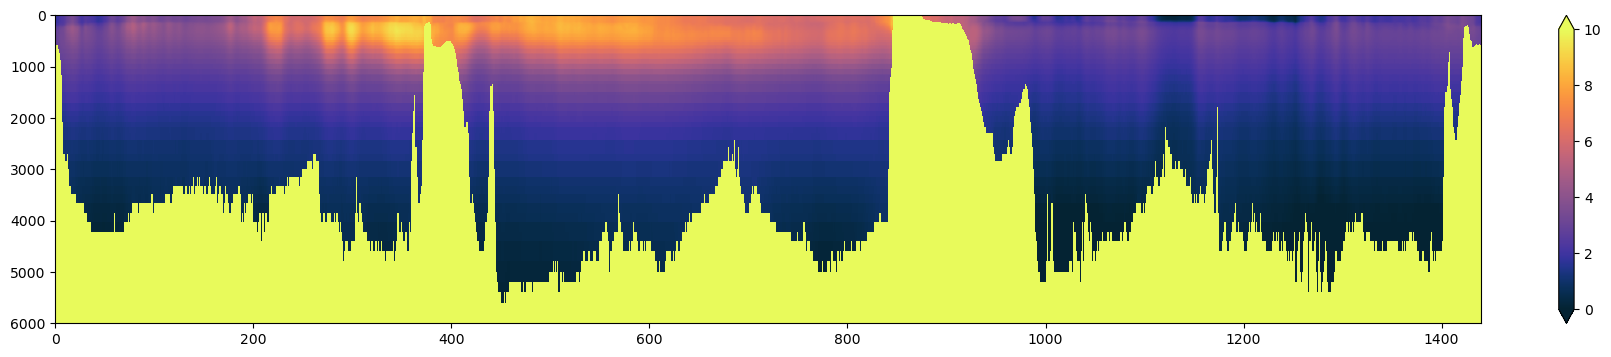

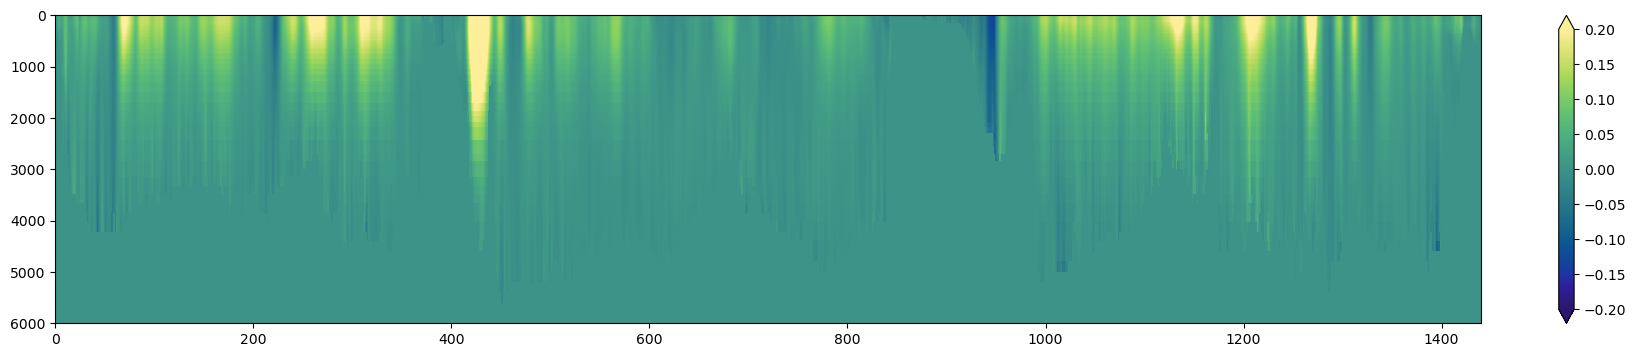

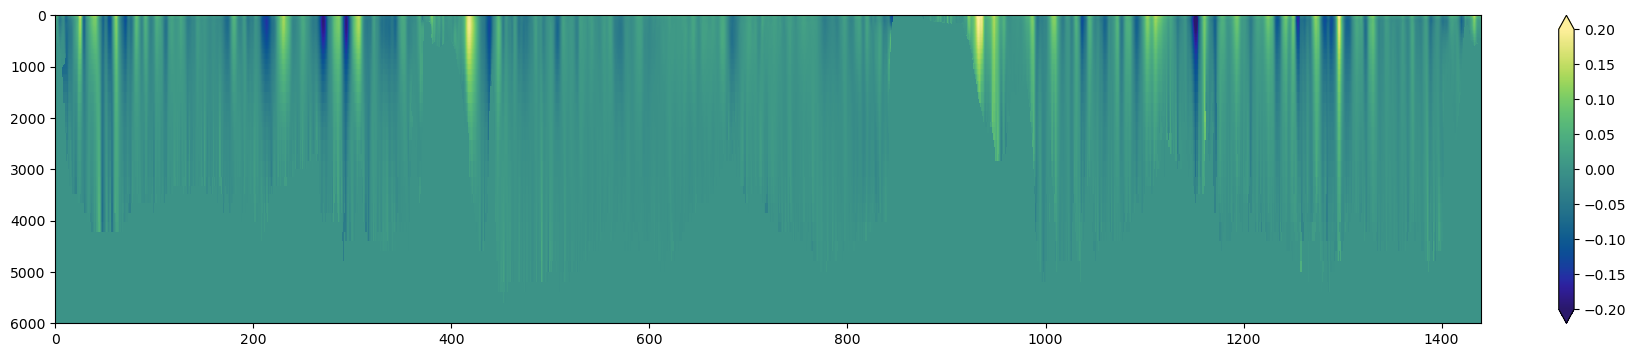

In [93]:
fig, ax = plot_cross_section(bdy_cond_S.SALT, yind=0, vlim=(33.6,35))
fig, ax = plot_cross_section(bdy_cond_T.THETA, yind=0, vlim=(0,10), cmap=cmocean.cm.thermal)
fig, ax = plot_cross_section(bdy_cond_U.UVEL, yind=0, vlim=(-0.2,0.2))
fig, ax = plot_cross_section(bdy_cond_V.VVEL, yind=0, vlim=(-0.2,0.2))

(-1.5, 0.5)

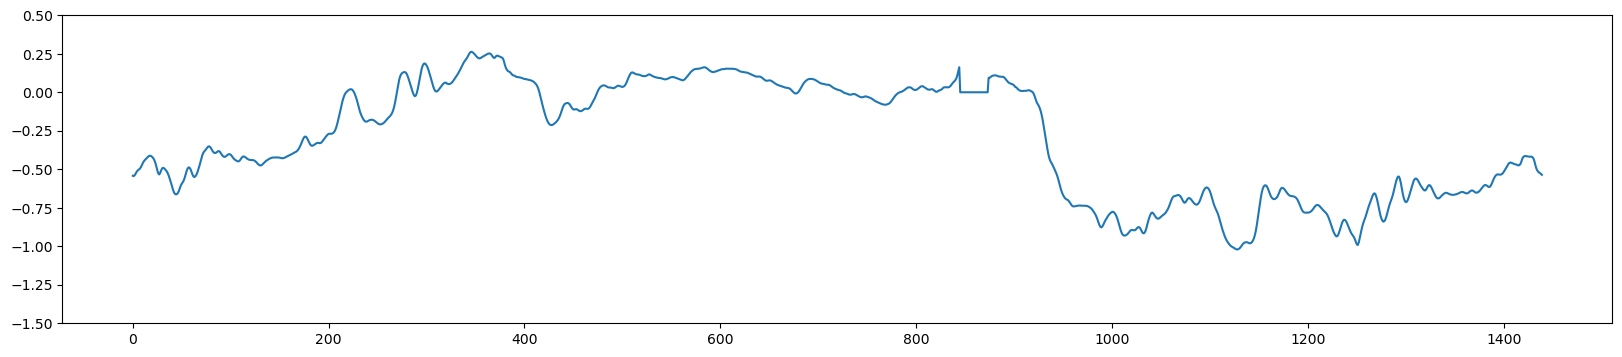

In [94]:
fig, ax = plt.subplots(1,1, figsize=(20,4))
ax.plot(ds0.zos.x_grid_T, bdy_cond_SSH.ETAN.isel(y=0))
ax.set_ylim(-1.5,0.5)

### Old

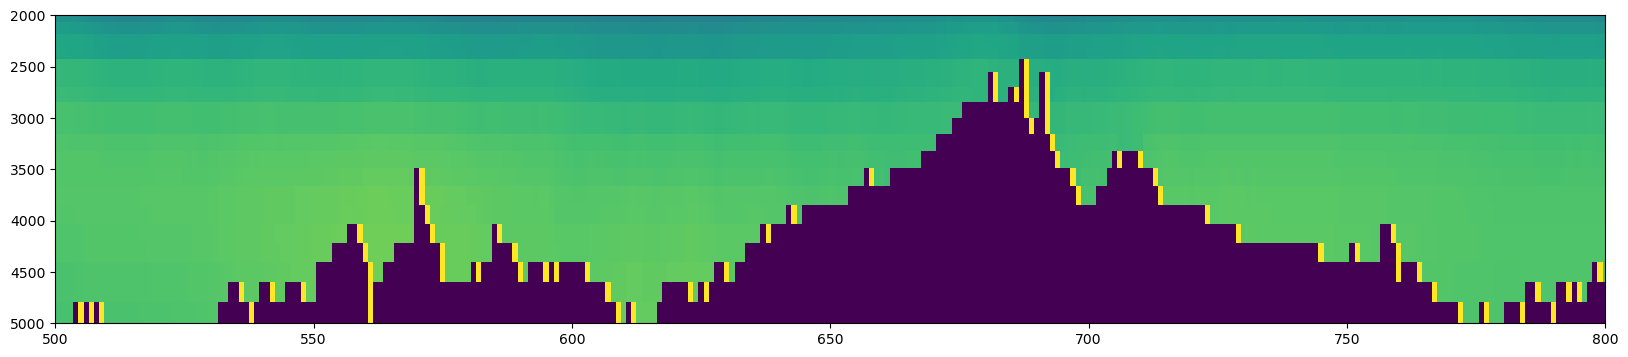

In [26]:
fig, ax = plot_cross_section(ds1.so, yind=451, ylim=(5000,2000), xlim=(500,800), vlim=(34.6, 35))

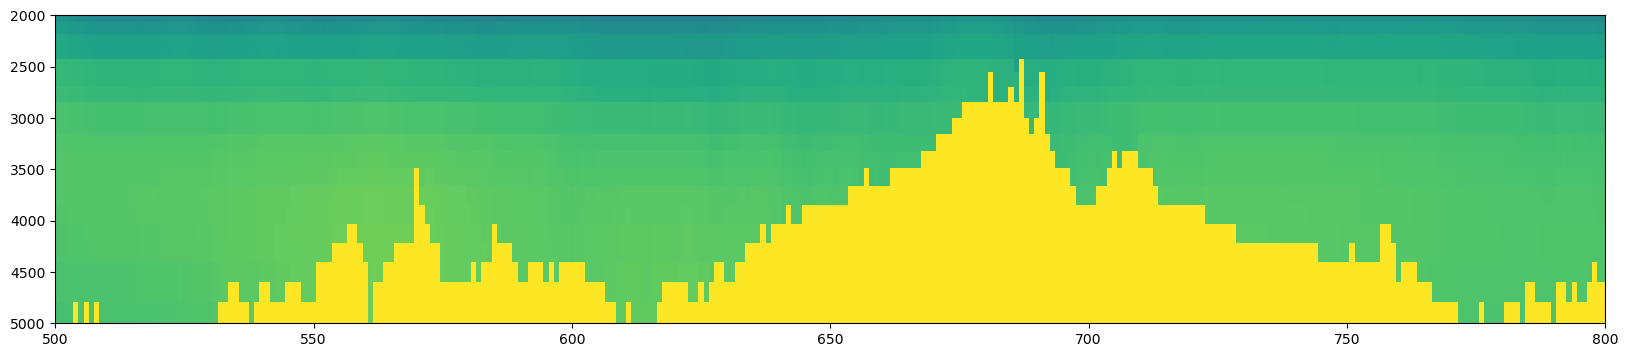

In [52]:
fig, ax = plot_cross_section(bdy_cond_new.SALT, yind=0, ylim=(5000,2000), xlim=(500,800), vlim=(34.6, 35))

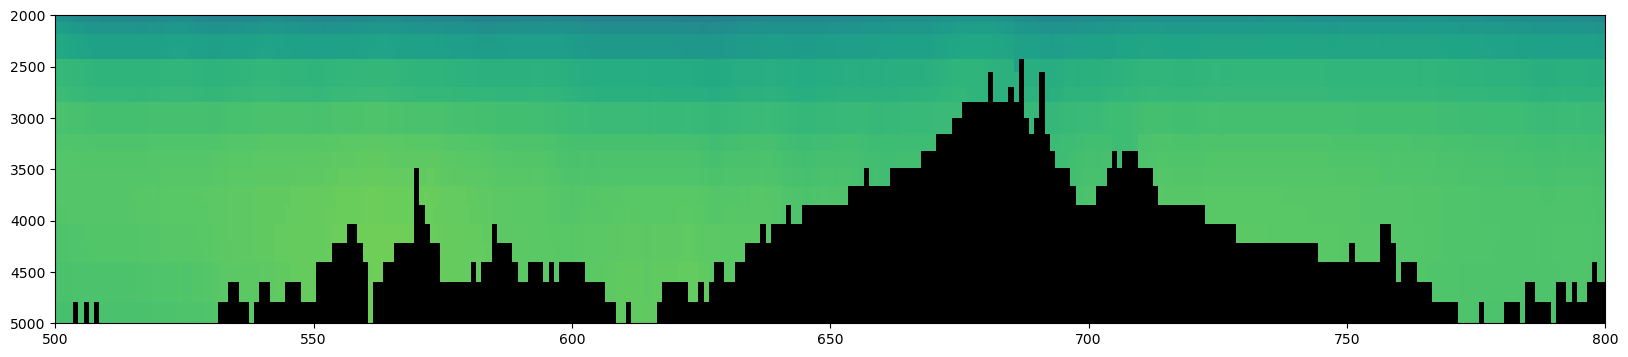

In [53]:
fig, ax = plot_cross_section(bdy_cond_new.SALT, yind=0, ylim=(5000,2000), xlim=(500,800), vlim=(34.6, 35))
plot_land = np.ma.masked_where(mesh_mask.tmask.isel(y=451)==1, mesh_mask.tmask.isel(y=451))
ax.pcolormesh(np.arange(1,1441,1), domain_cfg.nav_lev, plot_land, cmap=cmocean.cm.gray)

So, the landmasking is fine, but somehow the boundary condition x-coordinates are shifted by one point relative to the landmask that NEMO sees. I should check whether this is an issue with the initial conditions as well. It seems like NEMO interprets the landmask as shifted by one point. This seems like it would be likely due to Fortran versus Python based indexing, but I'm not sure how this comes about. I'll submit a test run with it shifted.

In [40]:
dsv = xr.open_dataset(f'{terra}boundary-conditions/B-SOSE/temp/SOSE-SALT-BC-vertical-interp.nc')

(<Figure size 2000x400 with 1 Axes>, <AxesSubplot:>)

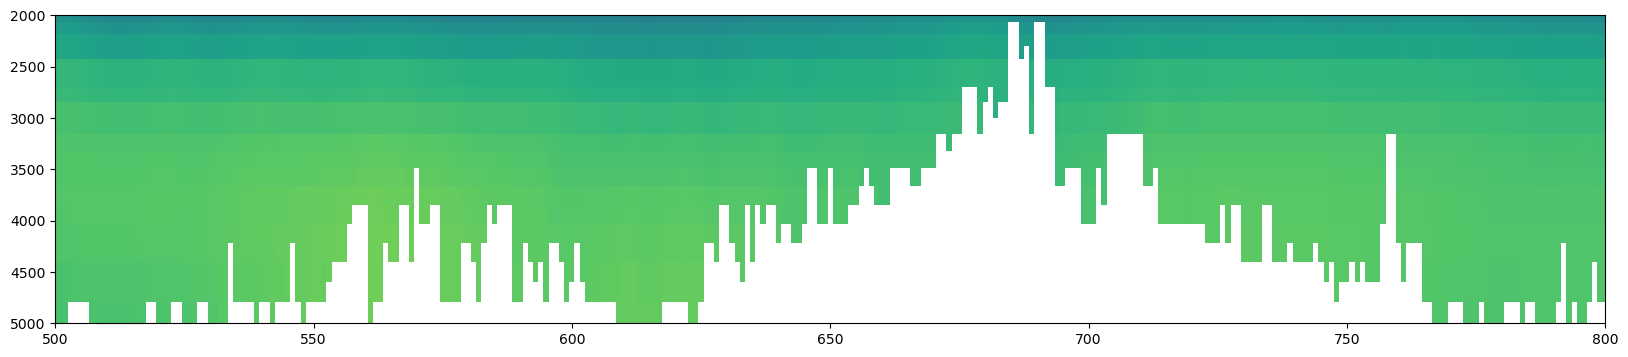

In [59]:
plot_cross_section(dsv.SALT, yind=0, ylim=(5000,2000), xlim=(500,800), vlim=(34.6, 35))

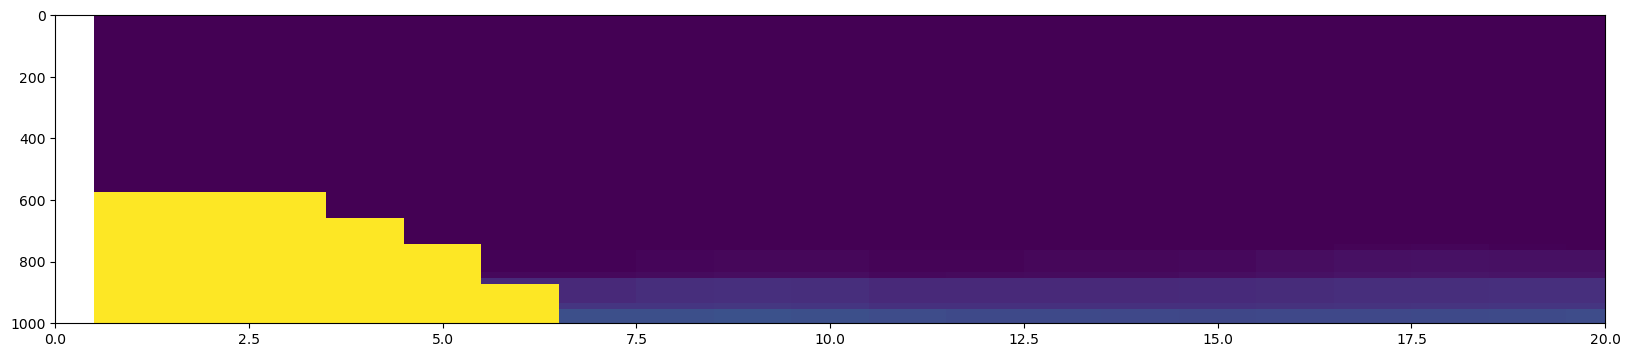

In [77]:
fig, ax = plot_cross_section(bdy_cond_new.SALT, yind=0, ylim=(1000,0), xlim=(0,20), vlim=(34.6, 35))

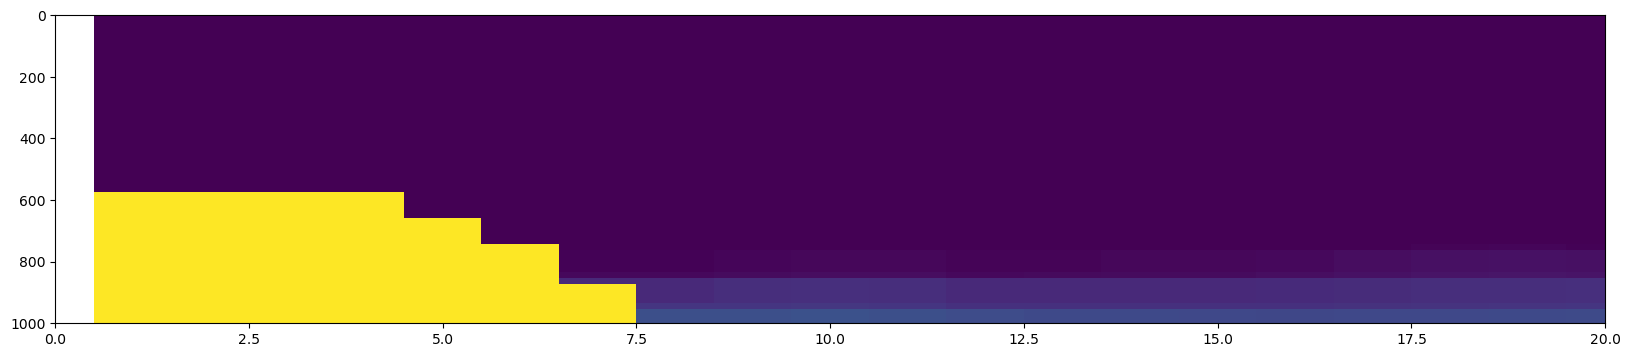

In [87]:
fig, ax = plot_cross_section(bdy_cond_new.SALT.roll(x=1), yind=0, ylim=(1000,0), xlim=(0,20), vlim=(34.6, 35))

Also need to check whether these issues apply to UVEL, VVEL and sea ice boundary conditions (sea ice shouldn't really matter because it'll all be zeros)